# Logistic Regression: Banking Marketing Campaign

**TODO**

1. Replace text feature composition output with plots
2. Refactor month/day encoding and feature composition helper functions to utils.py
3. ~~Set notebook wide random seed~~
4. Do hyperparameter optimization on class weigth with MCC loss
5. Penalty defaults to *l2* - should we be running with *None* and possibly discussing over-fitting?
6. Re: #5, should we be introducing cross-validation here or later?
6. Run final model on test data

## 1. Data Acquisition & EDA

### 1.1. Load the data

In [1]:
import pandas as pd

# Set notebook wide random seed - this makes the random number generator determistic - we should get the same
# result every time we run things with randomness, e.g. test-train split
random_seed=315

# Read the data into a pandas dataframe from the URL
data_url='https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv'
data_df=pd.read_csv(data_url, sep=';')

### 1.2. Train-test split

First thing's first - train test split the data. During EDA and feature engineering we are going to dig into this dataset and we don't want **ANY** information from or about the test set going into the design of the data pipeline or model. This would compromise the validity of our test set. Remember, the test set exists to see how the model will perform on new data - in a real deployment, the model will be used to make predictions on new data as it comes in. To get a realistic proxy of that situation, we need to leave the test data completely unknown.

In [2]:
from sklearn.model_selection import train_test_split

# First separate the features from the labels
labels=data_df['y']
features=data_df.drop('y', axis=1)

# Do the test-train split
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.33, 
    random_state=random_seed
)

Lots of data to work with here - some numerical features but also a lot of string/object types which are probably categorical and ordinal or interval. Let's take a closer look (**note**: looking at the training data only!):

In [3]:
# Inspect the first few rows, transposing so columns don't get cut off
training_features.head().transpose()

,22762,5889,20999,24505,9191
age,45,52,56,46,35
job,technician,blue-collar,blue-collar,admin.,unemployed
marital,divorced,married,married,married,married
education,professional.course,basic.4y,basic.4y,high.school,university.degree
default,no,no,no,unknown,no
housing,yes,yes,yes,no,no
loan,no,no,no,no,no
contact,cellular,telephone,cellular,cellular,telephone
month,aug,may,aug,nov,jun
day_of_week,mon,mon,thu,mon,fri


Beyond the Pandas datatypes, we have a few different kinds of variables here in the statistical sense:

1. **Ordinal**: 'categorical' variables like *education* which have a natural order, but no quantitative interval or magnitude.
2. **Interval**: for example, *month* has defined degrees of difference between the categories. 
3. **Nominal**: things like *marital* which have categories only, no obvious quantity or order.

These types in particular will be interesting, because we will need to handle encoding them to numerical features differently based on their properties. I also see several discrete and continuous random variables like *age* and *duration*.

There are a couple of other features that peak my interest too, but in terms of data quality:

1. *poutcome*: first 5 values are 'nonexistent' - I assume that means we don't know the outcome of the previous marketing campaign?
2. *day_of_week* (and others): is Monday call day and this feature is constant - cant tell from *head()*?
3. *pdays*: is 999 some kind of place holder for missing data? Is this value maybe constant too?

Let's check how many unique values we have for each feature. This information will guide us in deciding how to encode the data for regression and if we should drop any features from the get-go.

### 1.2. Unique and/or missing values

In [4]:
training_features.nunique()

age                 76
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1412
campaign            41
pdays               25
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          310
nr.employed         11
dtype: int64

OK, not so bad. Looks like calls happen on weekdays - 5 unique values. No constant columns that are begging to be dropped. I'm still curious about *default*, *housing*, *loan* and *poutcome* - it seems like they should be binary but each has three values - I bet it's missing data. Looking at the few rows we inspected above it seems like the string 'unknown' is being used for missing data. Let's find out how much data is missing.

In [5]:
# Define a reusable helper function here, since we will be looking at feature composition a lot
def feature_composition(df: pd.DataFrame, features: list) -> None:
    '''Takes a dataframe and a list of features. Prints out
    the unique levels of that feature with their count and 
    percent.'''

    for i, column_name in enumerate(features):
        value_counts=df[column_name].value_counts().T.to_dict()

        print(f'\nFeature: {column_name}')

        for key, value in value_counts.items():
            percent_value=(value/len(data_df)) * 100
            print(f' {key}: {value} ({percent_value:.1f}%)')

In [6]:
feature_composition(training_features, ['default','housing','loan','poutcome'])


Feature: default
 no: 21808 (52.9%)
 unknown: 5785 (14.0%)
 yes: 2 (0.0%)

Feature: housing
 yes: 14415 (35.0%)
 no: 12505 (30.4%)
 unknown: 675 (1.6%)

Feature: loan
 no: 22736 (55.2%)
 yes: 4184 (10.2%)
 unknown: 675 (1.6%)

Feature: poutcome
 nonexistent: 23810 (57.8%)
 failure: 2853 (6.9%)
 success: 932 (2.3%)


We have very, very few *defaults* - this column is a good candidate for exclusion based on low entropy. It's mostly missing or 'no' - probably not adding much information. Interestingly, both *housing* and *loan* are missing a large number of rows. We could maybe drop those examples as missing/bad data. Let's look at the weird '999' value in *pdays*. I bet that's a placeholder of some kind too.

In [7]:
feature_composition(training_features, ['pdays'])


Feature: pdays
 999: 26567 (64.5%)
 3: 291 (0.7%)
 6: 280 (0.7%)
 4: 83 (0.2%)
 9: 46 (0.1%)
 7: 41 (0.1%)
 2: 40 (0.1%)
 12: 39 (0.1%)
 10: 35 (0.1%)
 5: 33 (0.1%)
 13: 21 (0.1%)
 1: 18 (0.0%)
 11: 18 (0.0%)
 14: 17 (0.0%)
 8: 13 (0.0%)
 15: 12 (0.0%)
 0: 11 (0.0%)
 16: 9 (0.0%)
 17: 8 (0.0%)
 18: 6 (0.0%)
 22: 2 (0.0%)
 19: 2 (0.0%)
 27: 1 (0.0%)
 25: 1 (0.0%)
 26: 1 (0.0%)


Ok, now this makes sense - from the metadata, *pdays* is 'Number of days that elapsed since the last campaign until the customer was contacted (numeric)'. The 999 value is probably missing data here too, but it also could be for people who we have data for but were not included in the previous campaign - this qualitatively tracks with the large percentage of people for which the outcome of the previous campaign is unknown. Whatever the explanation, this is a fairly low entropy column too.

## 2. Feature engineering

### 2.1. Feature drops

I think the first thing we should do it just get rid of features related to the previous campaign - I don't think there is enough data about it to be meaningful. This way we loose some low entropy features and make the model simpler, without giving up any rows. Less is more.

In [8]:
# Names of columns to drop
column_drops=['poutcome', 'pdays', 'previous']

# Do the drops
training_features.drop(column_drops, axis=1, inplace=True)

# Do the same thing to the testing data
testing_features.drop(column_drops, axis=1, inplace=True)

# Take a look
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27595 entries, 22762 to 29283
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             27595 non-null  int64  
 1   job             27595 non-null  object 
 2   marital         27595 non-null  object 
 3   education       27595 non-null  object 
 4   default         27595 non-null  object 
 5   housing         27595 non-null  object 
 6   loan            27595 non-null  object 
 7   contact         27595 non-null  object 
 8   month           27595 non-null  object 
 9   day_of_week     27595 non-null  object 
 10  duration        27595 non-null  int64  
 11  campaign        27595 non-null  int64  
 12  emp.var.rate    27595 non-null  float64
 13  cons.price.idx  27595 non-null  float64
 14  cons.conf.idx   27595 non-null  float64
 15  euribor3m       27595 non-null  float64
 16  nr.employed     27595 non-null  float64
dtypes: float64(5), int64(3), object(

### 2.2. Feature encoding
#### 2.2.1. Categorical/interval features

Next, let's deal with the time features. Interval time features are better encoded with sin/cos components than single numbers - this method catches the 'near-ness' of Sunday to Monday or December to February where just numbering the months or days does not. If you are interested in cyclical encoding for time features check out [this Kaggle notebook](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning).

Here is what the features look like to start with:

In [9]:
feature_composition(training_features, ['day_of_week'])


Feature: day_of_week
 thu: 5790 (14.1%)
 mon: 5690 (13.8%)
 wed: 5423 (13.2%)
 tue: 5402 (13.1%)
 fri: 5290 (12.8%)


In [10]:
feature_composition(training_features, ['month'])


Feature: month
 may: 9143 (22.2%)
 jul: 4780 (11.6%)
 aug: 4161 (10.1%)
 jun: 3618 (8.8%)
 nov: 2772 (6.7%)
 apr: 1765 (4.3%)
 oct: 474 (1.2%)
 sep: 398 (1.0%)
 mar: 358 (0.9%)
 dec: 126 (0.3%)


In [11]:
import numpy as np

# Don't worry about downcasting FutureWarning
pd.set_option('future.no_silent_downcasting', True)

# Define a helper function here so we can encode the time
# features the same way on the training and testing data
# without copy-pasting the same code
def encode_time_features(data_df: pd.DataFrame) -> pd.DataFrame:
    '''Takes a Pandas dataframe and uses cyclical sin/cos to encode
    month and day features. Returns updated dataframe.'''

    # First convert the features to numeric
    dict={'mon' : 1, 'tue' : 2, 'wed': 3, 'thu' : 4, 'fri': 5}
    data_df=data_df.replace(dict)

    dict={'jan' : 1, 'feb' : 2, 'mar': 3, 'apr' : 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    data_df=data_df.replace(dict)

    # And fix the dtypes
    data_df['day_of_week']=data_df['day_of_week'].astype(int)
    data_df['month']=data_df['month'].astype(int)

    # Now encode the day and month with sin/cos components
    data_df['day_sin'] = np.sin(2 * np.pi * data_df['day_of_week']/7.0)
    data_df['day_cos'] = np.cos(2 * np.pi * data_df['day_of_week']/7.0)

    data_df['day_sin'] = np.sin(2 * np.pi * data_df['day_of_week']/7.0)
    data_df['day_cos'] = np.cos(2 * np.pi * data_df['day_of_week']/7.0)

    data_df['month_sin'] = np.sin(2 * np.pi * data_df['month']/12.0)
    data_df['month_cos'] = np.cos(2 * np.pi * data_df['month']/12.0)

    # Drop the original string features
    data_df.drop(['month', 'day_of_week'], axis=1, inplace=True)

    return data_df

In [12]:
# Encode the training and testing features the same way
training_features=encode_time_features(training_features)
testing_features=encode_time_features(testing_features)

#### 2.2.2. Categorical/ordinal feature

Next, let's look at education and job and make sure we encode those in a way that makes sense. Here are their levels:

In [13]:
feature_composition(training_features, ['education'])


Feature: education
 university.degree: 8097 (19.7%)
 high.school: 6426 (15.6%)
 basic.9y: 4038 (9.8%)
 professional.course: 3465 (8.4%)
 basic.4y: 2834 (6.9%)
 basic.6y: 1568 (3.8%)
 unknown: 1154 (2.8%)
 illiterate: 13 (0.0%)


Encode these in order of increasing education level:

In [14]:
# Dictionary to translate employment string to numerical value
dict={'unknown': 0, 'illiterate': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4, 'high.school': 5, 'professional.course': 6, 'university.degree': 7}

# Encode the training and testing data
training_features=training_features.replace(dict)
testing_features=testing_features.replace(dict)

# Fix the dtypes
training_features['education']=training_features['education'].astype(int)
testing_features['education']=testing_features['education'].astype(int)


And similarly for employment:

In [15]:
feature_composition(training_features, ['job'])


Feature: job
 admin.: 7002 (17.0%)
 blue-collar: 6225 (15.1%)
 technician: 4463 (10.8%)
 services: 2643 (6.4%)
 management: 1950 (4.7%)
 retired: 1177 (2.9%)
 entrepreneur: 995 (2.4%)
 self-employed: 932 (2.3%)
 housemaid: 708 (1.7%)
 unemployed: 686 (1.7%)
 student: 586 (1.4%)
 0: 228 (0.6%)


Was thinking that maybe we could do the same trick for employment - but it's hard to order the job types in a way that makes sense. If we could find where these classes came from - maybe some state department of labor statistics or something - we could maybe translate them to income level... But, let's leave it alone for now.

#### 2.2.3. Categorical/nominal features

For nominal features, we don't want to simply number the classes - this tells the model that they have a magnitude. For example, if we were to number the *housing* categories as follows:


```bash
unknown: 0
yes: 1
no: 2
```

it would imply that 'no' is somehow double 'yes' - makes no sense. The proper way to do this is with 'one hot' encoding. This technique uses a new binary categorical feature for each level of the original scale. Every example then gets a '1' to indicate it's level in the original feature. Here's what one hot encoding a few hypothetical examples for *housing* would look like:

|          | housing_unknown | housing_yes | housing_no |
|----------|-----------------|-------------|------------|
| Person 1 |        1        |      0      |     0      |
| Person 2 |        0        |      0      |     1      |
| Person 3 |        0        |      1      |     0      |

However, there is one issue with this: the above table looks intuitively good, but it introduces multicolinearity. Notice how the sum of all three one hot encoding features for any row is one? This is a problem for many machine learning models and is known as the 'dummy variable' problem. Without going into too much detail, we actually only need two one hot encoded variables to encode three feature levels and only four to encode five levels and so on. It's always one less than the original levels we are trying to encode. If you are interested in this topic check out this [Medium article](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a)

Luckily, this type of encoding is a very common operation and Pandas *get_dummies()* can handle it for us - just be sure to set *drop_first* to **True**.

In [16]:
# Names of columns we want to encode
encoded_columns=['job','marital','default','housing','loan','contact']

# Do the encoding
training_features=pd.get_dummies(training_features, columns=encoded_columns, dtype=int, drop_first=True)
testing_features=pd.get_dummies(testing_features, columns=encoded_columns, dtype=int, drop_first=True)

training_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27595 entries, 22762 to 29283
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                27595 non-null  int64  
 1   education          27595 non-null  int64  
 2   duration           27595 non-null  int64  
 3   campaign           27595 non-null  int64  
 4   emp.var.rate       27595 non-null  float64
 5   cons.price.idx     27595 non-null  float64
 6   cons.conf.idx      27595 non-null  float64
 7   euribor3m          27595 non-null  float64
 8   nr.employed        27595 non-null  float64
 9   day_sin            27595 non-null  float64
 10  day_cos            27595 non-null  float64
 11  month_sin          27595 non-null  float64
 12  month_cos          27595 non-null  float64
 13  job_admin.         27595 non-null  int64  
 14  job_blue-collar    27595 non-null  int64  
 15  job_entrepreneur   27595 non-null  int64  
 16  job_housemaid      2759

### 2.3. Feature standardization

Last feature engineering step will be to standardize our numerical features. The goal here is to bring all of the features into a similar range. Just because the values for *nr.employed* are larger than those for *euribor3m* does not mean it is more important. The important thing is the variation in those feature and their relationship to the target variable.

For more information, check out the article on [preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html) from the scikit-learn documentation.

In [17]:
training_features.head()

,age,education,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,day_sin,...,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_telephone
22762,45,6,112,2,1.4,93.444,-36.1,4.965,5228.1,0.781831,...,1,0,0,1,0,0,1,1,0,0
5889,52,2,253,2,1.1,93.994,-36.4,4.857,5191.0,0.781831,...,0,1,0,1,0,0,1,1,0,1
20999,56,2,366,1,1.4,93.444,-36.1,4.964,5228.1,-0.433884,...,0,1,0,1,0,0,1,1,0,0
24505,46,5,76,3,-0.1,93.200,-42.0,4.191,5195.8,0.781831,...,0,1,0,0,0,1,0,1,0,0
9191,35,7,360,2,1.4,94.465,-41.8,4.967,5228.1,-0.974928,...,0,1,0,1,0,1,0,1,0,1


In [18]:
from sklearn.preprocessing import StandardScaler

# Scale the features
standard_scaler=StandardScaler().fit(training_features)
training_features=standard_scaler.transform(training_features)
testing_features=standard_scaler.transform(testing_features)

print(f'Training features are: {type(training_features)}')
print(f'Training features shape: {training_features.shape}')

Training features are: <class 'numpy.ndarray'>
Training features shape: (27595, 34)


### 2.4. Label encoding

Last thing to do before we can train a model is encode our labels to a binary categorical variable.

In [19]:
from sklearn.preprocessing import LabelEncoder

# Last, encode the labels
label_encoder=LabelEncoder().fit(training_labels)
training_labels=label_encoder.transform(training_labels)
testing_labels=label_encoder.transform(testing_labels)

print(f'Training labels: {training_labels}')

Training labels: [0 0 0 ... 0 0 0]


## 3. Classifier optimization

Let's start with the off-the-shelf *LogisticRegression* from scikit-learn and see how it does. This will be our baseline of comparison to determine if anything we are doing to optimize it is having a real effect. Take a look a the official [documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html), this is always the primary source for information about what a class, method, or functions does and how to use it.

### 3.1. Naive scikit-learn *LogisticRegression*

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the model on the training data
base_model=LogisticRegression(random_state=random_seed)
base_model.fit(training_features, training_labels)

# Make predictions
base_training_predictions=base_model.predict(training_features)

# Score for accuracy
percent_accuracy=accuracy_score(training_labels, base_training_predictions) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the training data.')

Model is 90.8% accurate on the training data.


OK, it's a start - a few things to note:

1. The 'real' performance on the test set will likely not be this good.
2. The model is not guessing 'no' all the time - this is a good thing, it means we are accomplishing something.

How do I know #2? The training data is 88.8% 'no' examples, labeling everything 'no' would be correct 88.8% of the time:

In [21]:
print(f'Data is {float(1 - (sum(training_labels) / len(training_labels))) * 100:.1f}% "no"')

Data is 88.9% "no"


### 3.2. Class weighted scikit-learn *LogisticRegression*

First optimization to with an unballanced classifiaction problem is to weigtht the classes. Doing so tells the model to give more importance to examples from the minor class. Once again scikit-learn has this built in - set the *class_weight* argument to *balanced*.

In [22]:
# Train the model
weighted_model=LogisticRegression(random_state=random_seed, class_weight='balanced')
weighted_model.fit(training_features, training_labels)

# Make predictions
weighted_training_predictions=weighted_model.predict(training_features)

# Score for accuracy
percent_accuracy=accuracy_score(training_labels, weighted_training_predictions) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the training data.')

Model is 85.1% accurate on the training data.


- **Question**: OK, wait - hang on - the accuracy went down?
- **Answer**: Yes! But this is actually a better result!

## 4. What? A note about interpretation & classification accuracy

Accuracy is often a terrible metric for classification performance. To see why, let's think about this data problem for a minute. Why are we building this classifier anyways? A likely business use case for this type of model is targeting sales & advertising spend. We don't want to waste a bunch of time and money calling people who aren't going to take out a deposit. There are much better metrics for this type of situation. To build some intuition about why accuracy is not great for this task, let's imagine a hypothetical scenario and see what effect our models have on the bank's bottom line.

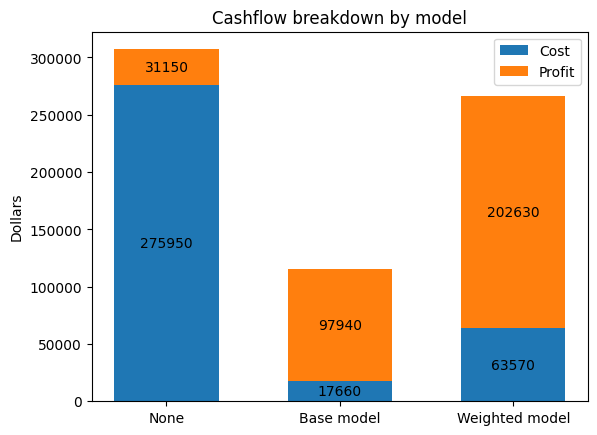

In [23]:
import matplotlib.pyplot as plt
from utils import calculate_cashflow

# Made up number for how much it costs to call one customer
# to advertise the deposit
cost_to_call_customer=10

# Made up number for how much money we get from each deposit we sell
return_on_deposit=100

# Run our toy example
results, models=calculate_cashflow(
    training_features,
    training_labels,
    base_training_predictions,
    weighted_training_predictions,
    cost_to_call_customer,
    return_on_deposit
)

# Plot the results
bottom=np.zeros(3)
width=0.6

# Plot the portion of total income that is profit and expense
for var, value in results.items():
    p=plt.bar(models, value, width, label=var, bottom=bottom)
    bottom += value

    plt.bar_label(p, label_type='center')

plt.title('Cashflow breakdown by model')
plt.ylabel('Dollars')
plt.legend()
plt.show()

You just earned the company an additional ~$170,000 on the next marketing campaign. This is why being a good data scientist is well paying job. When you see 'extract insight from data' or 'translate data into business impact' in a job call, this kind of thing is what they are talking about.

- **Question**: So, what happened? What is going on - how can the weighted model be so much better if the 'accuracy' went down?
- **Answer**: To understand why accuracy fails in this scenario, realize that there are two ways to be 'right' and two ways to be 'wrong' and they are not the same! Accuracy lumps them together.

The relevant data science terms here are:

**'Ways to be right'**:
1. <ins>True positives</ins>: number of positive examples correctly classified as positive (people we predicted would take the deposit that actually did)
2. <ins>True negatives</ins>: number of negative examples correctly classified as negative (people we predicted would not take the deposit that didn't take it)

**'Ways to be wrong'**:
1. <ins>False positives</ins>: number of negative examples incorrectly classified as positive (number of people we predicted would take the deposit who didn't take it)
2. <ins>False negatives</ins>: number of positive examples incorrectly classified as negative (number of people we predicted would not take the deposit who did take it)

With no model at all, it is pretty obvious that we are spending way too much money making a lot of calls to people who aren't taking deposits. To understand what is going on with the base vs weighted model, take a look at the confusion matrices:

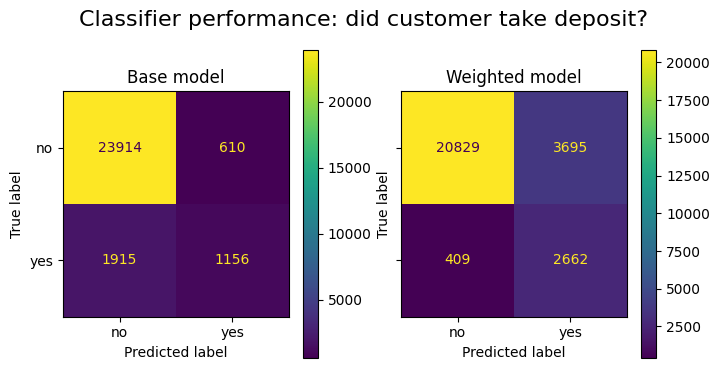

Model base model is 90.8% accurate on the training data.
Model weighted model is 85.1% accurate on the weighted data.


In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

# Set-up two subplots for the training and testing confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Set the figure and individual plot titles
fig.suptitle('Classifier performance: did customer take deposit?', fontsize=16)
axes[0].set_title('Base model')
axes[1].set_title('Weighted model')

# Plot the training data performance
_=ConfusionMatrixDisplay.from_estimator(
    estimator=base_model,
    X=training_features,
    y=training_labels,
    display_labels=label_encoder.classes_,
    #normalize='all',
    ax=axes[0]
)

# Plot the testing data performance
_=ConfusionMatrixDisplay.from_estimator(
    estimator=weighted_model,
    X=training_features,
    y=training_labels,
    display_labels=label_encoder.classes_,
    #normalize='all',
    ax=axes[1]
)

plt.show()

base_training_predictions=base_model.predict(training_features)
percent_accuracy=accuracy_score(training_labels, base_training_predictions) * 100
print(f'Model base model is {percent_accuracy:.1f}% accurate on the training data.')

weighted_training_predictions=weighted_model.predict(training_features)
percent_accuracy=accuracy_score(training_labels, weighted_training_predictions) * 100
print(f'Model weighted model is {percent_accuracy:.1f}% accurate on the weighted data.')

The base model is more conservative with it's predictions overall - it predicts 'yes' less often. In doing so, it makes fewer incorrect predictions, resulting it a higher overall accuracy. But, it predicts 'no' when it should have predicted 'yes' more often than the weighted model does. Therefore it misses out on a lot of revenue! The weighted model is more aggressive. It predicts 'yes' much more often overall and gets a lower 'accuracy' score. But, because the revenue from a deposit is greater than the cost to call the customer, it performs better by missing fewer sales than the base model.

This is a common type of scenario, where the true costs of the error types are not equal. Similarly, the benefits of the correct prediction types may also not be equal. For this reason, it is always a good idea to look at a confusion matrix when evaluating a classification model.

## 5. Classification loss: binary cross-entropy

So how can we tell that the weighted model is 'better' than the base model without the complicated example or looking at a plot? If we are doing, for example, automated hyperparameter optimization, it's nice to have a single number we can directly compare. There are many options for this type of thing - but one in particular that is useful in this case is the Matthews correlation coefficient. It does a much better job of taking true and false negative and positives into account than accuracy alone:

In [25]:
from sklearn.metrics import matthews_corrcoef

base_mcc=matthews_corrcoef(training_labels, base_training_predictions)
weighted_mcc=matthews_corrcoef(training_labels, weighted_training_predictions)

print(f'Base model Mathews correlation: {base_mcc:.3f}')
print(f'Weighted Mathews correlation: {weighted_mcc:.3f}')

Base model Mathews correlation: 0.452
Weighted Mathews correlation: 0.535


Better - now we can tell that our weighted model is doing a better job of capturing what is going on in the dataset in a way that reflects our goal. There are many, many other metrics for all sorts of classification problems. The [Scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) is a great place to start if you are interested to know what is out there beyond simple 'accuracy'.